In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

#updated below function so that it will only take in the first 3 min for calculations...
def calculate_frame_brightness(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    frame_brightness = []
    frame_number = 0
    max_frames = 100
    
    while frame_number < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate the average brightness
        avg_brightness = np.mean(gray_frame)
        frame_brightness.append(avg_brightness)
        
        frame_number += 1
    
    cap.release()
    return frame_brightness

def find_brightness_drop(brightness_values, threshold):
    drops = []
    for i in range(1, len(brightness_values)): 
        if brightness_values[i-1] - brightness_values[i] > threshold:
            drops.append(i)
    return drops

def process_videos(base_path, cameras, threshold):
    drop_frames = {}
    for camera in cameras:
        video_path = os.path.join(base_path, camera, '0.mp4')
        brightness_values = calculate_frame_brightness(video_path)
        
        drop_frame = find_brightness_drop(brightness_values, threshold)
        if drop_frame is not None:
            drop_frames[camera] = drop_frame
        else:
            print(f"No significant drop found in first 3 min in {video_path}")

        plt.plot(brightness_values, label=camera)
    
    plt.title('Frame Brightness Over Time')
    plt.xlabel('Frame Number, first 3 min')
    plt.ylabel('Average Brightness')
    plt.legend()
    plt.show()

    return drop_frames

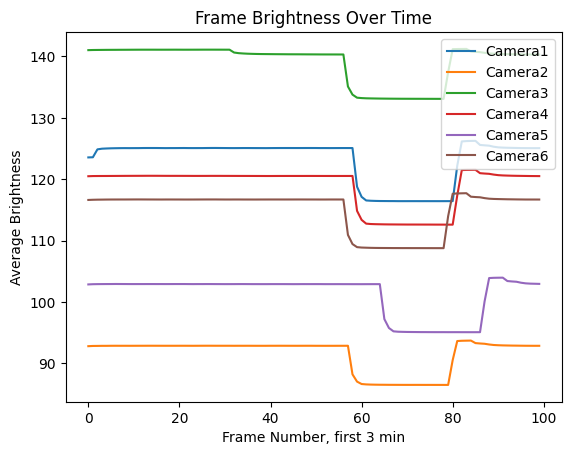

Detected drop frames: {'Camera1': [59], 'Camera2': [58], 'Camera3': [57], 'Camera4': [59], 'Camera5': [65], 'Camera6': [57]}


In [2]:
# Define base path and camera list
base_path = '/hpc/group/tdunn/lq53/sync_camera_/rawvid_mirstop_30s_light_3'
vi_path = os.path.join(base_path, 'videos')
calib_file = os.path.join(base_path, '30s_exposuretest_label3d_dannce.mat')
cameras = [f'Camera{i}' for i in range(1, 7)]  # 2, 7 if camera 1 is dead
threshold = 3  # Adjust this threshold if needed

# Process videos and find brightness drops
drop_frames = process_videos(vi_path, cameras, threshold)
print("Detected drop frames:", drop_frames)

# # Synchronize videos
# outpath = '/hpc/group/tdunn/lq53/sync_camera_/rawvid_mirstop_30s_light_3/synced_w_sync/videos'
# sync_videos(base_path, outpath, cameras, drop_frames)

In [18]:
import scipy.io

calib_data = scipy.io.loadmat(calib_file)


sync = calib_data['sync']



In [4]:
def align_frames(data_sampleID, drop_frame):
    new_sampleID = data_sampleID.copy()
    num_frames = data_sampleID.size

    # Set the drop frame to 0
    new_sampleID[drop_frame] = 0

    # Adjust frames after the drop frame
    new_sampleID[drop_frame+1:] = range(1, num_frames - drop_frame)

    # Adjust frames before the drop frame
    new_sampleID[:drop_frame] = range(-drop_frame, 0)

    return new_sampleID

In [19]:
for cam_idx in range(6):
    camera_key = f'Camera{cam_idx+1}'
    drop_frame = drop_frames[camera_key][0]

    # Access the data_sampleID for the current camera
    data_sampleID = sync[cam_idx][0]['data_sampleID'][0][0][0] #data_sampleID

    # Align the frames
    new_data_sampleID = align_frames(data_sampleID, drop_frame)

    # Update the sync structure with the new data_sampleID
    sync[cam_idx][0]['data_sampleID'][0][0][0] = new_data_sampleID #data_sampleID

In [21]:
# Find common frame numbers across all cameras
keyyyyy = 'data_sampleID'
all_frames = [sync[cam_idx][0][keyyyyy][0][0][0] for cam_idx in range(6)] #data_sampleID
common_frames = set(all_frames[0])
for frames in all_frames[1:]:
    common_frames.intersection_update(frames)

# Mark frames not in common set as NaN
for cam_idx in range(6):
    data_sampleID = sync[cam_idx][0][keyyyyy][0][0][0] #data_sampleID
    mask = np.isin(data_sampleID, list(common_frames))
    data_sampleID[~mask] = np.nan

    #test if this will change things positive/start with 0
    counter = 0
    for i in range(len(data_sampleID)):
        if np.isnan(data_sampleID[i]):
            counter = 0  # Reset counter after NaN
        elif mask[i]:  # Adjust only for frames in the common set
            data_sampleID[i] = counter
            counter += 1

    sync[cam_idx][0][keyyyyy][0][0][0] = data_sampleID #data_sampleID

In [28]:
calib_data['sync'] = sync
save_path = os.path.join(base_path, 'pos_synced_30s_label3d_dannce.mat')
scipy.io.savemat(save_path, calib_data)

In [29]:
sync[3][0]['data_sampleID'][0][0][0]#[0] #data_sampleID

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,   0.,   1.,   2.,
         3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
       124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.,
       135., 136., 137., 138., 139., 140., 141., 14

In [10]:
# data_sampleID_list[0][0][0][0]

NameError: name 'data_sampleID_list' is not defined